In [4]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

# 下載 CkipTagger 的預訓練模型，下載的路徑為"./"，並且生出data資料夾
data_utils.download_data_gdown("./")

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=106dd168-d745-4384-9a9f-db7eb1840184
To: d:\NTU\全球品牌管理\Final Projects\data.zip
100%|██████████| 1.88G/1.88G [03:05<00:00, 10.1MB/s]


In [5]:
# 初始化 WS(斷詞)、POS(詞性標註)、NER(命名實體識別) 的工具，模型路徑為 "./data"
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
  3%|▎         | 61.9M/1.88G [05:19<2:36:15, 194kB/s]
c:\Users\brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [48]:
import pandas as pd

comments_df = pd.read_csv('comments.csv')

comments_df['Text'] = comments_df['Text'].apply(lambda x: x.replace('\n', ' '))

main_floor = ['B{}'.format(i) for i in range(1, 422)]
main_comments = comments_df[comments_df['樓層數(ex 1, 1-1)'].isin(main_floor)]
other_comments = comments_df[~comments_df['樓層數(ex 1, 1-1)'].isin(main_comments)]
other_floor = ['B{}-{}'.format(i, j) for i in range(1, 422) for j in range(1, 59)]
all_floor = main_floor + other_floor

# print(comments_df.columns)
aspect_col = ['價格', '尺寸', '品質', '服務態度', '舒適度', '公關', '代言', '外觀']
comments_df['品牌'].fillna('D+AF', inplace=True)
comments_df[aspect_col].fillna(0, inplace=True)


def remove_floor(text, floor):
    text = text.replace(floor, ' ')
    for f in all_floor:
        text = text.replace(f, ' ')
    return text

comments_df['Text'] = comments_df.apply(lambda x: remove_floor(x['Text'], x['樓層數(ex 1, 1-1)']), axis=1)
# D_AF_dict = ['D家', 'D+AF', 'D牌', 'd+f', 'd+af', 'd家', 'd牌', 'd+af家', 'd+af牌', 'd家牌', 'd+af牌', 'D 牌', 'd 牌']
# amai_dict = ['amai', 'Amai', 'A牌', 'a牌', 'AmaX', 'amax', 'AmaX牌', 'amax牌', 'A 牌', 'a 牌']
# grace_dict = ['Grace', 'G牌', 'g牌', 'grace gift', 'Grace Gift', 'grace', 'Grace牌', 'g牌', 'grace gift牌', 'gra', 'gra gif', 'Gra', 'gra牌', 'Gra牌', 'gracegift', 'Gracegift', 'gracegift牌', 'Gracegift牌', 'GraXce GXft', 'G 牌', 'g 牌']
# ann_dict = ['ann', 'Ann', 'ann牌', 'Ann牌', 'ANNS', 'anns', "Ann's", "ann's"]
# GU_dict = ['GU', 'gu', 'GU牌', 'gu牌', "Gu"]
# c_h_shoe_dict = ['C&H', 'C&H shoe', 'C&H SHOE', 'C&H Shoes', 'C&H shoes', 'c&h', 'c&h shoe', 'c&h SHOE', 'C&H牌', 'C&H SHOE牌', 'c&h牌', 'c&h shoe牌', 'c&h SHOE牌']
# RM_dict = ['RM', 'rm', 'RM牌', 'rm牌']
# vac_dict = ['vacxxza', 'vacanza', 'vaca']
# avivi_dict = ['avivi', 'Avivi', 'avivi牌', 'Avivi牌', 'avivi girl']
# chuan_dict = ['chuan']

# brand_dict = {'Amai': amai_dict, 'Grace Gift': grace_dict, "Ann's": ann_dict, 'GU': GU_dict, 'C&H': c_h_shoe_dict, 'RM': RM_dict, 'vacanza': vac_dict, 'avivi': avivi_dict, 'chuan': chuan_dict, 'D+AF': D_AF_dict}

def concat_text(text):
    # check if text contains floor name
    for floor in all_floor:
        if floor in text:
            # get text of the floor corresponding to comments_df['樓層數(ex 1, 1-1)']
            text = text.replace(floor, ' ')
            # concat text of the floor
            text += ' '.join(comments_df[comments_df['樓層數(ex 1, 1-1)'] == floor]['Text'].values)
            break
    return text

# comments_df['Concat_text'] = comments_df['Text'].apply(concat_text)

def get_brand(text):
    for brand, brand_list in brand_dict.items():
        for b in brand_list:
            if b in text:
                return brand
    return 'D+AF'

others_list = ['GU', 'C&H', 'RM', 'vacanza', 'avivi', 'chuan']
comments_df['品牌'] = comments_df['品牌'].apply(lambda x: 'others' if x in others_list else x)
comments_df[aspect_col] = comments_df[aspect_col].applymap(lambda x: 1 if x == 1 else 0)

from transformers import BertTokenizer, BertForTokenClassification
from transformers import pipeline

# 使用預訓練的中文情感分析模型
sentiment_pipeline = pipeline("sentiment-analysis", model="uer/roberta-base-finetuned-jd-binary-chinese")
# 測試文本
text = "B413 真的難穿到爆！"

# 進行情感分析
sentiment = sentiment_pipeline(text)
print(sentiment)

# get both sentiment score and label
def get_sentiment(text):
    sentiment = sentiment_pipeline(text)
    return sentiment[0]

comments_df['Sentiment'] = comments_df['Text'].apply(get_sentiment)

# get sentiment label
def get_sentiment_label(text):
    return text['label']

comments_df['Sentiment_label'] = comments_df['Sentiment'].apply(get_sentiment_label)

# get sentiment score
def get_sentiment_score(text):
    score = text['score']
    if text['label'] == 'negative (stars 1, 2 and 3)':
        return -score
    return score

comments_df['Sentiment_score'] = comments_df['Sentiment'].apply(get_sentiment_score)

comments_df.to_csv('result.csv', index=False, encoding='utf-8-sig')

C:\Users\brian\AppData\Local\Temp\ipykernel_8276\4274726786.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df[aspect_col].fillna(0, inplace=True)


[{'label': 'negative (stars 1, 2 and 3)', 'score': 0.7271652221679688}]


In [47]:
print(comments_df.head(5))

  樓層數(ex 1, 1-1) 重新編碼                                               Text  價格  \
0             B1   B1  我也有發現！雖說是陸製但我更看重材質，好穿的話哪一個國家製我根本不在乎！重點是它們家的鞋子真...   0   
1           B1-1   B2                     我覺得在淘寶單價超過500以上的東西通常比台灣差不多價錢的好   1   
2           B1-2   B3                                 真的很難穿 穿一次之後就封印了🥲🥲🥲   0   
3           B1-6   B7               淘寶認真挑很多都材質很好 我是覺得沒必要反陸製畢竟生活中一堆東西都是陸製   0   
4             B2  B14  大腳女生經過  之前曾經買過D+AF幾雙鞋 嘗試幾次都是穿到起水泡跟鞋子縫線繃開... 還有...   0   

   尺寸  品質  服務態度  舒適度  公關  代言  外觀    品牌  \
0   0   1     0    1   0   0   0  D+AF   
1   0   1     0    0   0   0   0  D+AF   
2   0   0     0    1   0   0   0  D+AF   
3   0   1     0    0   0   0   0  D+AF   
4   1   1     0    1   0   0   0  D+AF   

                                           Sentiment  \
0  {'label': 'negative (stars 1, 2 and 3)', 'scor...   
1  {'label': 'positive (stars 4 and 5)', 'score':...   
2  {'label': 'negative (stars 1, 2 and 3)', 'scor...   
3  {'label': 'positive (stars 4 and 5)', '

In [30]:
# # print concat text of B2-1

brand_list = comments_df['品牌'].unique()

# print(comments_df[comments_df['樓層數(ex 1, 1-1)'] == 'B2-1']['Concat_text'].values[0])
# print(comments_df['Brand'].value_counts())

print(comments_df['Sentiment'].value_counts())  
print()

# for brand in brand_list:
#     print(brand)
#     print(comments_df[comments_df['品牌'] == brand]['Sentiment'].value_counts())
#     print()

# get D+AF comments sentiment of each aspect
# for aspect in aspect_col:
#     print(aspect)
#     print(comments_df[(comments_df['品牌'] == 'D+AF') & (comments_df[aspect] == 1)]['Sentiment'].value_counts())
#     print()

# build each brand sentiment of each aspect as csv

# print(comments_df['品牌'].value_counts())



Sentiment
negative (stars 1, 2 and 3)    378
positive (stars 4 and 5)       217
Name: count, dtype: int64

品牌
D+AF        475
amai         30
grace        28
ann          27
gu            5
C&H           5
RM            5
ck            4
net           4
東京企劃          3
chuan         2
vacanza       2
達芙妮           1
淘寶            1
avivi         1
anns          1
Airspace      1
Name: count, dtype: int64


In [8]:

# main_comments_text = main_comments['Text'].tolist()
# word_sentence_list = ws(main_comments_text)
# pos_sentence_list = pos(word_sentence_list)
# entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

word_sentence_list = ws(comments_df['Text'].tolist())
pos_sentence_list = pos(word_sentence_list)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

In [58]:

# 定義一個印出斷詞和詞性標註結果的函數
def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000")
    print()
    return



for i, sentence in enumerate(word_sentence_list):
    print()
    print(f"'{sentence}'")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


'['我', '也', '有', '發現', '！', '雖說', '是', '陸製', '但', '我', '更', '看重', '材質', '，', '好', '穿', '的話', '哪', '一', '個', '國家', '製', '我', '根本', '不', '在乎', '！', '重點', '是', '它們', '家', '的', '鞋子', '真的', '！', '真的', '！', '不', '好', '穿', '！', '😭 ', '至少', '也', '挑', '一下', '材質', '吧', '！', '不要', '一味', '一直', '狂', '打', '廣告', '，', '品質', '卻', '是', '堪憂', '啊', '！']'
我(Nh)　也(D)　有(D)　發現(VE)　！(EXCLAMATIONCATEGORY)　雖說(Cbb)　是(SHI)　陸製(VC)　但(Cbb)　我(Nh)　更(Dfa)　看重(VJ)　材質(Na)　，(COMMACATEGORY)　好(VH)　穿(VC)　的話(Cba)　哪(Nep)　一(Neu)　個(Nf)　國家(Na)　製(VC)　我(Nh)　根本(D)　不(D)　在乎(VK)　！(EXCLAMATIONCATEGORY)　重點(Na)　是(SHI)　它們(Nh)　家(Nc)　的(DE)　鞋子(Na)　真的(D)　！(EXCLAMATIONCATEGORY)　真的(D)　！(EXCLAMATIONCATEGORY)　不(D)　好(VH)　穿(VC)　！(EXCLAMATIONCATEGORY)　😭 (FW)　至少(Da)　也(D)　挑(VC)　一下(Nd)　材質(Na)　吧(T)　！(EXCLAMATIONCATEGORY)　不要(D)　一味(D)　一直(D)　狂(VH)　打(VC)　廣告(Na)　，(COMMACATEGORY)　品質(Na)　卻(D)　是(SHI)　堪憂(VH)　啊(T)　！(EXCLAMATIONCATEGORY)　
(9, 11, 'ORG', '陸製')

'['大腳', '女生', '經過', '  ', '之前', '曾經', '買', '過', 'D+AF', '幾', '雙', '鞋', ' ', '嘗試', '幾', '次', '都', '是', '穿到',

In [42]:
# print all sentences contains 'FW' in pos

# for i, sentence in enumerate(word_sentence_list):
#     if 'FW' in pos_sentence_list[i]:
#         for j, pos in enumerate(pos_sentence_list[i]):
#             if pos == 'FW':
#                 if sentence[j] in main_floor or sentence[j] in other_floor:
#                     continue
#                 elif sentence[j] in 

SyntaxError: invalid syntax (3824118235.py, line 9)

In [58]:
print(aspect_col)

['價格', '尺寸', '品質', '服務態度', '舒適度', '公關', '代言', '外觀']


價格


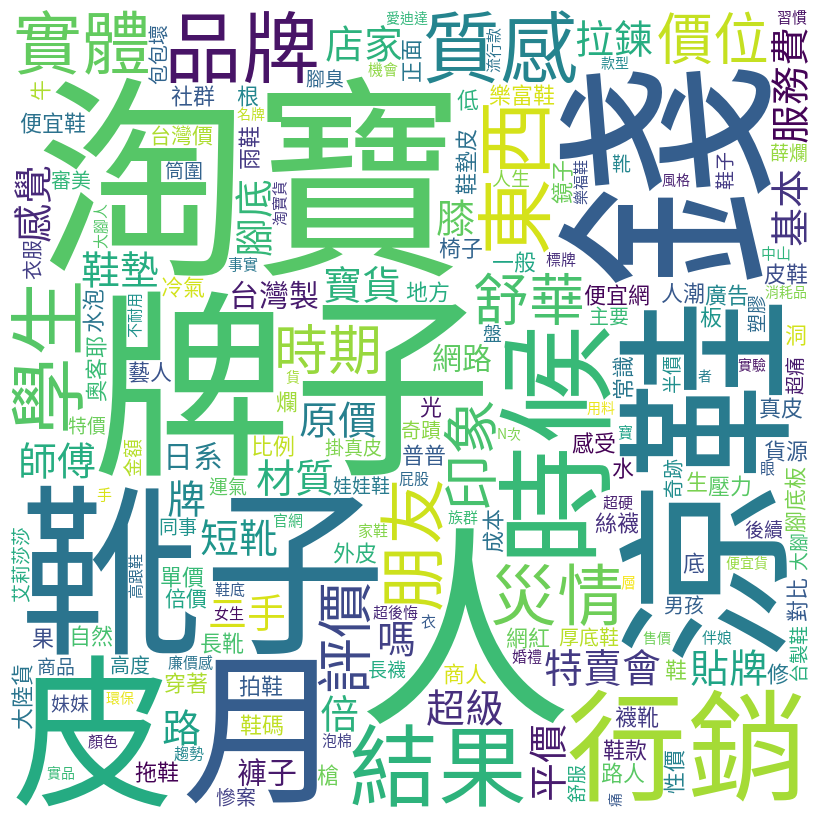

尺寸


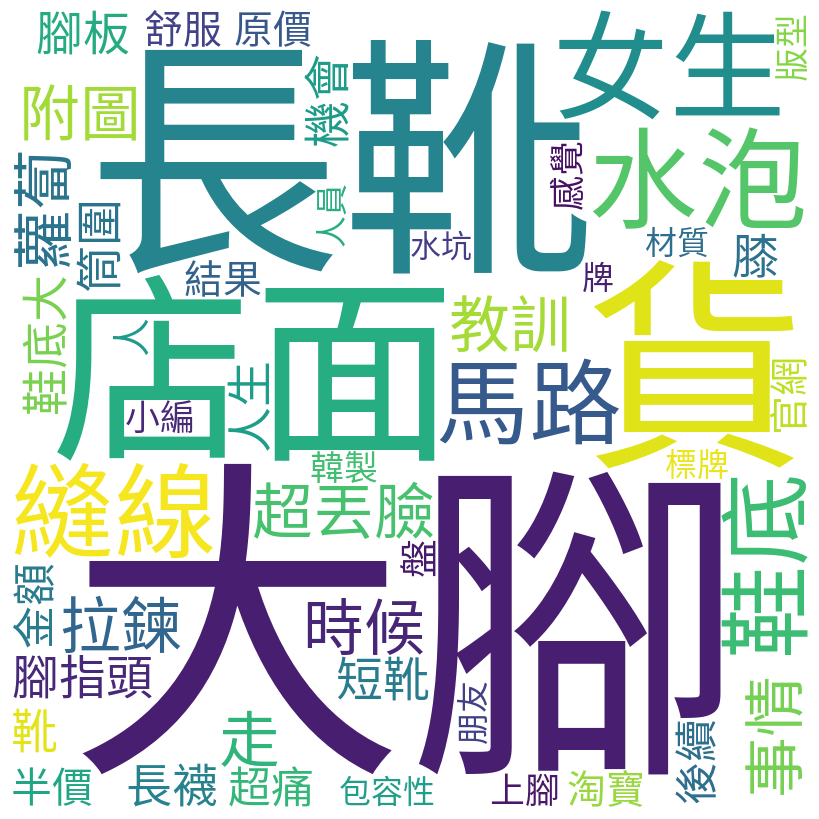

品質


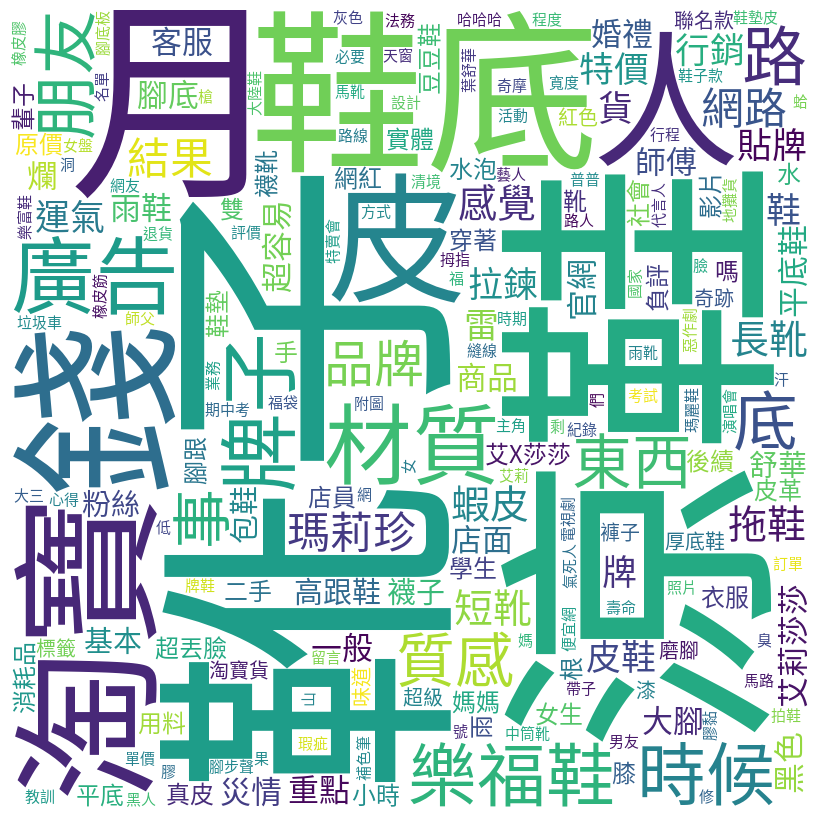

服務態度


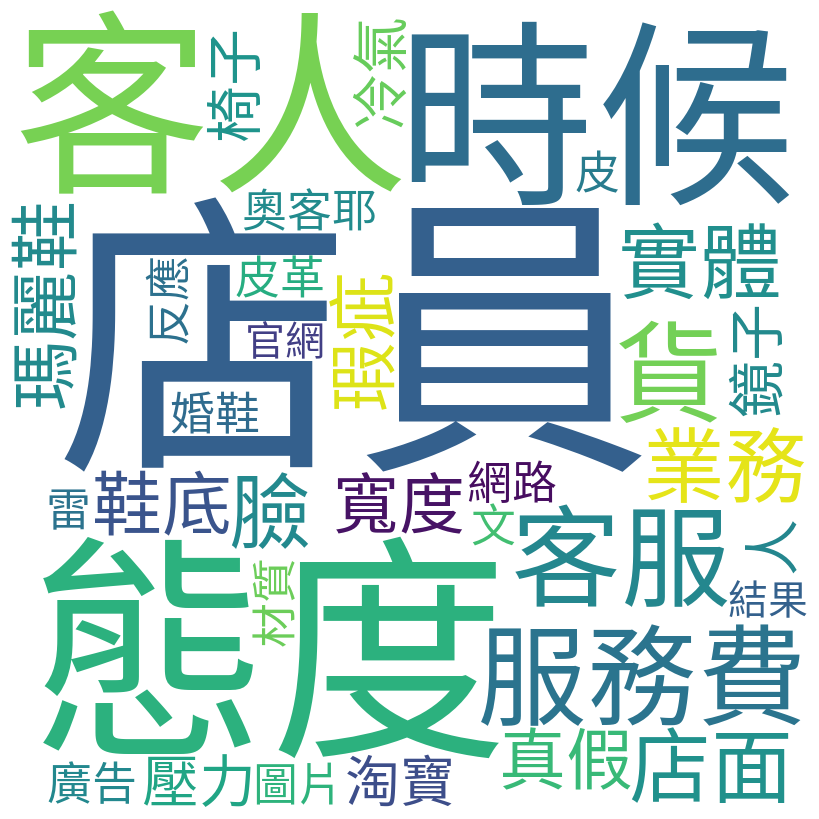

舒適度


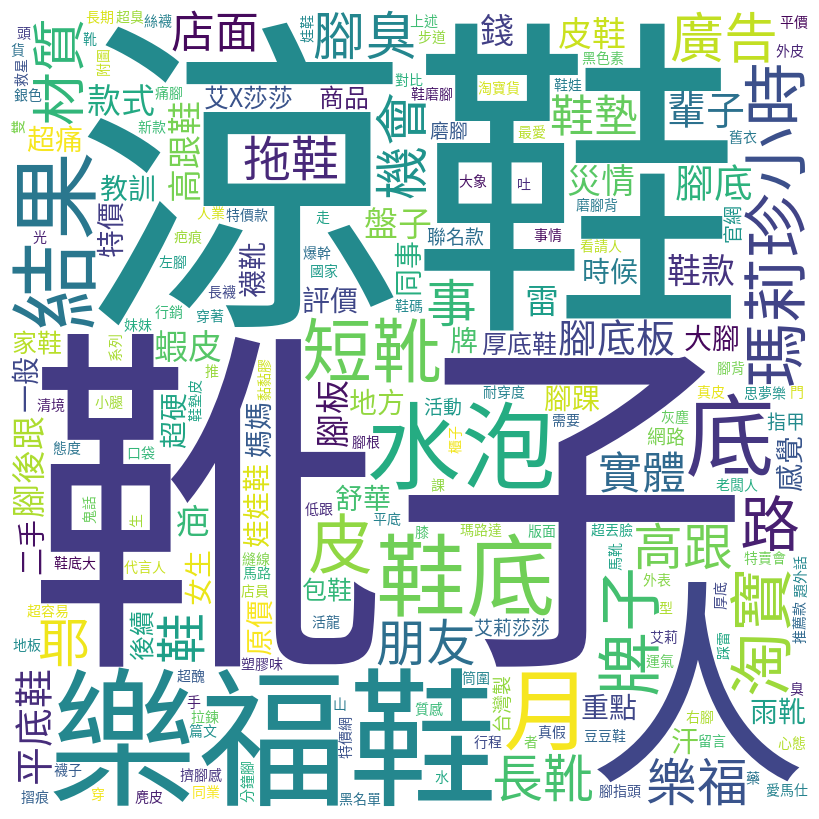

公關


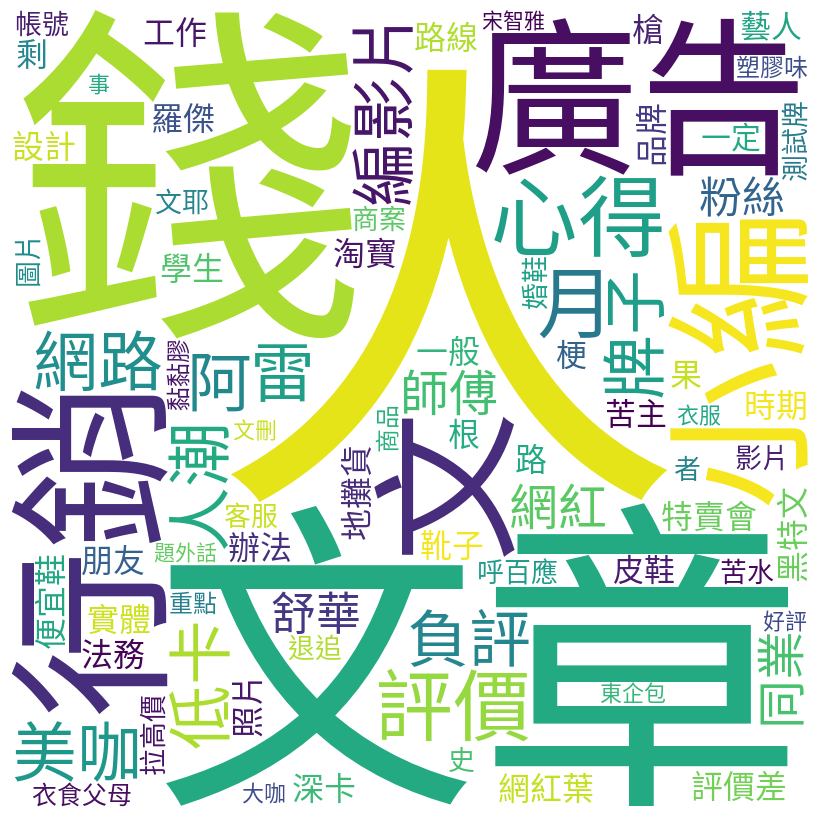

代言


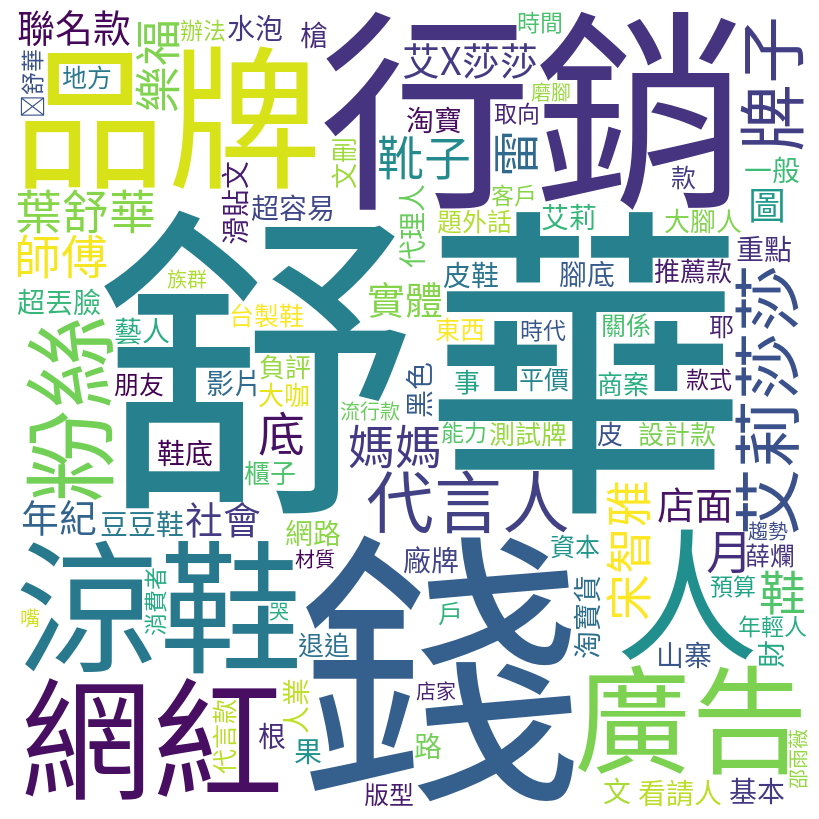

外觀


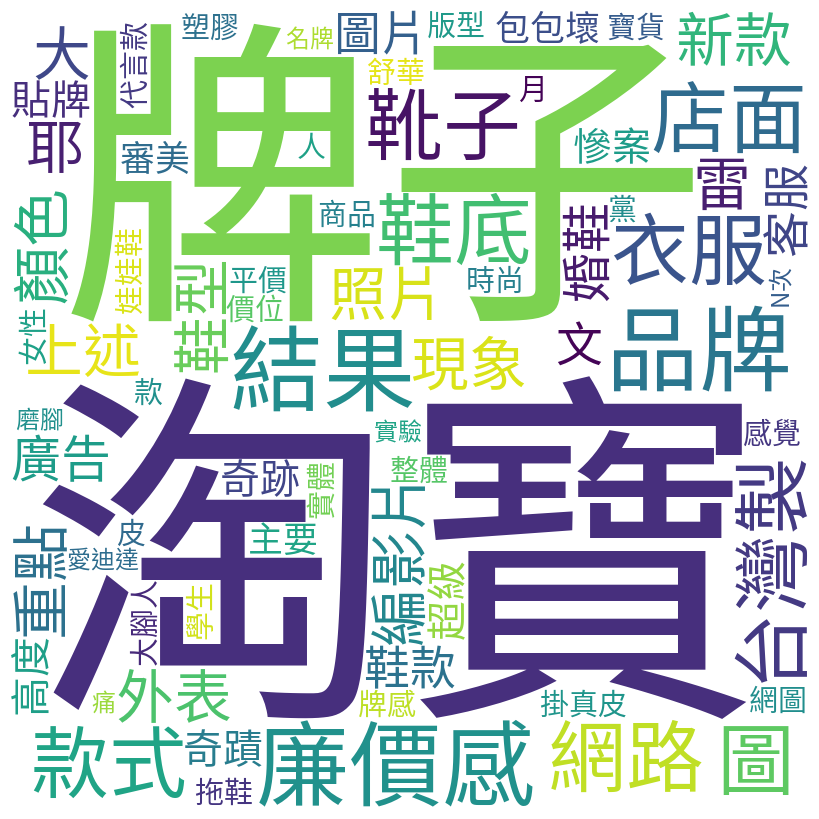

In [60]:
# word cloud

from wordcloud import WordCloud

import matplotlib.pyplot as plt

# word_sentence_list = ws(main_comments_text)

# leave only pos == 'A'

# for i, sentence in enumerate(word_sentence_list):
#     for j, pos_ in enumerate(pos_sentence_list[i]):
#         if pos_ not in ['A', 'Na', 'Nb']:
#             sentence[j] = ''

# create wordcloud for each brand

# for brand in brand_dict.keys():
#     brand_text = comments_df[comments_df['Brand'] == brand]['Text'].tolist()
#     word_sentence_list = ws(brand_text)
#     pos_sentence_list = pos(word_sentence_list)
#     entity_sentence_list = ner(word_sentence_list, pos_sentence_list)
#     # leave only pos == 'A', 'Na', 'Nb'
#     for i, sentence in enumerate(word_sentence_list):
#         for j, pos_ in enumerate(pos_sentence_list[i]):
#             if pos_ not in ['A', 'Na', 'Nb']:
#                 sentence[j] = ''
#     word_sentence_list = [word for sentence in word_sentence_list for word in sentence]
#     word_sentence_list = ' '.join(word_sentence_list)
#     font = 'SourceHanSansTW-Regular.otf'
#     wordcloud = WordCloud(width = 800, height = 800,
#                 background_color ='white',
#                 stopwords = None,
#                 font_path = font,
#                 min_font_size = 10).generate(word_sentence_list)
#     print(brand)
#     plt.figure(figsize = (8, 8), facecolor = None)
#     plt.imshow(wordcloud)
#     plt.axis("off")
#     plt.tight_layout(pad = 0)
#     plt.show()

# create wordcloud for D+AF of each aspect

for aspect in aspect_col:
    aspect_text = comments_df[(comments_df['品牌'] == 'D+AF') & (comments_df[aspect] == 1)]['Text'].tolist()
    word_sentence_list = ws(aspect_text)
    pos_sentence_list = pos(word_sentence_list)
    entity_sentence_list = ner(word_sentence_list, pos_sentence_list)
    # leave only pos == 'A', 'Na', 'Nb'
    for i, sentence in enumerate(word_sentence_list):
        for j, pos_ in enumerate(pos_sentence_list[i]):
            if pos_ not in ['A', 'Na', 'Nb']:
                sentence[j] = ''
            if sentence[j] in ['鞋子', '鞋', '腳', '品質', '價錢', '問題']:
                sentence[j] = ''
            if sentence[j] in aspect_col:
                sentence[j] = ''
    word_sentence_list = [word for sentence in word_sentence_list for word in sentence]
    word_sentence_list = ' '.join(word_sentence_list)
    font = 'SourceHanSansTW-Regular.otf'
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                font_path = font,
                min_font_size = 10).generate(word_sentence_list)
    print(aspect)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


# word_sentence_list = [word for sentence in word_sentence_list for word in sentence]

# word_sentence_list = ' '.join(word_sentence_list)





# font = 'SourceHanSansTW-Regular.otf'

# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color ='white',
#                 stopwords = None,
#                 font_path = font,
#                 min_font_size = 10).generate(word_sentence_list)

# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
# plt.show()

In [61]:
from senti_c import SentenceSentimentClassification

sentence_classifier = SentenceSentimentClassification(logging_level = "warning")

ModuleNotFoundError: No module named 'senti_c'